# TT1 - MDM UBA - 2025

**Tariff classification using NLP**

By Santiago Tedoldi

## Training a DistiltBERT for classification

In [2]:
# Dependencies
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.decomposition import PCA



### Raw dataset

In [3]:
colspecs = [(0, 6), (6, None)]
data_type = {'HS06': str}
df = pd.read_fwf('data/raw_data_HScodes_desc.txt',
                 colspecs=colspecs, header=None,
                 names=['HS06', 'GOODS_DESCRIPTION'],
                 dtype=data_type)

### Quick EDA

null and duplicated samples

dropping duplicates

analyzing tops and bottoms regarding frequencies

In [4]:
# Quick EDA
print("=== Quick EDA ===")

# Add HS02 (chapter) and HS04 (heading)
df['HS04'] = df['HS06'].str[:4]
df['HS02'] = df['HS06'].str[:2]

print("Nulls per column:")
print(df.isnull().sum(), "\n")

print("Duplicate rows:", df.duplicated().sum(), "\n")

# Function to build and display freq tables
def freq_table(col, name):
    vc      = df[col].value_counts().rename('count')
    rel     = df[col].value_counts(normalize=True).rename('rel_freq')
    cum     = rel.cumsum().rename('cum_freq')
    summary = pd.concat([vc, rel, cum], axis=1)
    summary['rel_freq'] = (summary['rel_freq'] * 100).round(2).astype(str) + '%'
    summary['cum_freq'] = (summary['cum_freq'] * 100).round(2).astype(str) + '%'

    print(f"## Samples per {name} ({col})\n")
    print("### Top 10")
    print(summary.head(10).to_markdown(), "\n")
    print("### Bottom 10")
    print(summary.tail(10).to_markdown(), "\n")

# Dropping duplicates
df.drop_duplicates(inplace=True)

# Chapter-level (HS02)
freq_table('HS02', 'chapter')

# Heading-level (HS04)
freq_table('HS04', 'heading')

# Subheading-level (HS06)
freq_table('HS06', 'subheading')

=== Quick EDA ===
Nulls per column:
HS06                 0
GOODS_DESCRIPTION    0
HS04                 0
HS02                 0
dtype: int64 

Duplicate rows: 232220 

## Samples per chapter (HS02)

### Top 10
|   HS02 |   count | rel_freq   | cum_freq   |
|-------:|--------:|:-----------|:-----------|
|     84 |   54901 | 20.5%      | 20.5%      |
|     85 |   33571 | 12.54%     | 33.04%     |
|     87 |   28476 | 10.63%     | 43.67%     |
|     73 |   16173 | 6.04%      | 49.71%     |
|     39 |   12218 | 4.56%      | 54.28%     |
|     90 |   11611 | 4.34%      | 58.61%     |
|     82 |    7972 | 2.98%      | 61.59%     |
|     94 |    7921 | 2.96%      | 64.55%     |
|     40 |    7526 | 2.81%      | 67.36%     |
|     83 |    4285 | 1.6%       | 68.96%     | 

### Bottom 10
|   HS02 |   count | rel_freq   | cum_freq   |
|-------:|--------:|:-----------|:-----------|
|     41 |      22 | 0.01%      | 99.96%     |
|     81 |      19 | 0.01%      | 99.97%     |
|     45 |      19 | 0

In [5]:
df

,HS06,GOODS_DESCRIPTION,HS04,HS02
0,271019,BRAKE FLUID DOT 4 50X200ML,2710,27
1,847710,PLASTIC INJECTION MOULD MODEL 21A 110G DSM1010...,8477,84
2,844399,LCD ASSEMBLY,8443,84
3,848280,BEARING 22238 KCAW33C3 BRAND MCB,8482,84
4,630900,USED HANDBAGS AND WALLETS,6309,63
...,...,...,...,...
499959,854239,PCB OPTIONAL ADD. KROPT V4.0 (NEW OUT PUT CARD),8542,85
499961,842091,CYLINDER (SDA80*10F003000001A),8420,84
499970,830249,BEOTIC DEVICE,8302,83
499981,901180,COMPOUND BINOCULAR MICROSCOPE,9011,90


Merging with HS06 nomenclature

In [6]:
df_hs06 = pd.read_csv('data/hs06_full_eng.csv', index_col='hs06', 
                      dtype={'hs06': str, 'full_eng': str},
                      usecols=['hs06', 'full_eng'])

In [7]:
# top 5 rows in HS06 nomemclature
print(df_hs06.head(5).to_markdown(), "\n")

# bottom 5 rows in HS06 nomemclature
print(df_hs06.tail(5).to_markdown(), "\n")

|   hs06 | full_eng                                                                              |
|-------:|:--------------------------------------------------------------------------------------|
| 010120 | Live horses, asses, mules and hinnies. && - Horses :                                  |
| 010121 | Live horses, asses, mules and hinnies. && - Horses : && -- Pure-bred breeding animals |
| 010129 | Live horses, asses, mules and hinnies. && - Horses : && -- Other                      |
| 010130 | Live horses, asses, mules and hinnies. && - Asses                                     |
| 010190 | Live horses, asses, mules and hinnies. && - Other                                     | 

|   hs06 | full_eng                                                                                                                                                                                                                                             |
|-------:|:------------------------------------

In [8]:
df = pd.merge(df, df_hs06,how='left', left_on='HS06', right_on='hs06')

In [9]:
print("Nulls per column:")
print(df.isnull().sum()/len(df), "\n")

Nulls per column:
HS06                 0.000000
GOODS_DESCRIPTION    0.000000
HS04                 0.000000
HS02                 0.000000
full_eng             0.045381
dtype: float64 



There are 4.5 % of goods with no HS full_eng available

They may are not updated codes

### Deep EDA

aggregate text statistics by HS level

performed in HSrecomm_EDA

Utils

In [10]:
# Utils f
def hs_frequencies_process(df, hs_codification = []):
    for hs_codi in hs_codification:

        df = df.merge(df[hs_codi].value_counts(), left_on=hs_codi, right_index=True)
        df.rename(columns={'count':f'{hs_codi}_samples'}, inplace=True)

    return df

def description_length(df, description_cols = []):
    for col in description_cols:

        df[f'{col}_len_words'] = df[col].apply(lambda x: len(x.split()))
        df[f'{col}_len_chars'] = df[col].apply(lambda x: len(x))

    return df

def subtokenization_indicator(description, tokenizer):
    words = description.lower().split()
    tokens = tokenizer.tokenize(description)
    return len(tokens)/len(words)

In [11]:
df.head()

,HS06,GOODS_DESCRIPTION,HS04,HS02,full_eng
0,271019,BRAKE FLUID DOT 4 50X200ML,2710,27,Petroleum oils and oils obtained from bitumino...
1,847710,PLASTIC INJECTION MOULD MODEL 21A 110G DSM1010...,8477,84,Machinery for working rubber or plastics or fo...
2,844399,LCD ASSEMBLY,8443,84,Printing machinery used for printing by means ...
3,848280,BEARING 22238 KCAW33C3 BRAND MCB,8482,84,"Ball or roller bearings. && - Other, including..."
4,630900,USED HANDBAGS AND WALLETS,6309,63,NaN


### DistilBERT model training

In [12]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizerFast, DistilBertModel

Sampling function

In [13]:
def bootstrap_sampling(df, test_fraction=0.1):
    # Determine the number of test samples
    n_test = int(len(df) * test_fraction)
    # Perform bootstrap sampling for the test set
    test_set = df.sample(n=n_test, replace=True)
    # Remove the test samples from the original dataframe to create the training set
    train_set = df.drop(test_set.index)
    
    return train_set, test_set

Dataset & DataLoader preparation

In [14]:
# Sampling for testing the pipeline
df = df.sample(frac=0.1, random_state=42)

In [15]:
# Load the tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

# Custom Dataset Class
class HS_Desc_Dataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length, label2id, 
                 hs_code_col = 'HS04', good_desc_col = 'GOODS_DESCRIPTION'):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.label2id = label2id
        self.hs_code_col = hs_code_col
        self.good_desc_col = good_desc_col

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx][self.good_desc_col]
        label = self.label2id[str(self.data.iloc[idx][self.hs_code_col])]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Create label mappings
unique_labels = df['HS04'].unique()
label2id = {str(label): idx for idx, label in enumerate(unique_labels)}
id2label = {idx: str(label) for idx, label in enumerate(unique_labels)}

# Split the data into train and validation sets
train_df, val_df = bootstrap_sampling(df, test_fraction=0.1)

# Create dataset instances
max_length = 300
train_dataset = HS_Desc_Dataset(dataframe=train_df, tokenizer=tokenizer, max_length=max_length, label2id=label2id)
val_dataset = HS_Desc_Dataset(dataframe=val_df, tokenizer=tokenizer, max_length=max_length, label2id=label2id)

# Batch size
batch_size = 32 # from 16 to speed up training

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

### Transfer learning

Model definition

Complexity adaptable to n_classes

In [16]:
# Define the custom model
class HSClassifier(nn.Module):
    def __init__(self, n_classes, fine_tune=False):
        super(HSClassifier, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained("distilbert-base-uncased")
        
        # Freeze the DistilBERT layers
        for param in self.distilbert.parameters():
            param.requires_grad = fine_tune # Whether to fine-tune the transformer model
        
        self.classifier = nn.Sequential(
            nn.Linear(self.distilbert.config.hidden_size, int(n_classes/3)),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(int(n_classes/3), int(n_classes/2)),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(int(n_classes/2), int(n_classes*1.5)),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(int(n_classes*1.5), n_classes)
        )
    
    def forward(self, input_ids, attention_mask):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = outputs.last_hidden_state[:, 0, :]  # Take <CLS> token representation
        logits = self.classifier(hidden_state)
        return logits

Training

In [17]:
# Accuracy functions
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.sum(preds == labels).item()

def top5_accuracy(outputs, labels):
    top5 = torch.topk(outputs, 5, dim=1).indices
    return sum([labels[i] in top5[i] for i in range(labels.size(0))])

# Training loop
def train_epoch(model, data_loader, criterion, optimizer, device):
    model = model.train()
    losses = []
    correct_predictions = 0
    correct_top5_predictions = 0
    
    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)

        correct_predictions += accuracy(outputs, labels)
        correct_top5_predictions += top5_accuracy(outputs, labels)
        
        losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    return correct_predictions / len(data_loader.dataset), correct_top5_predictions / len(data_loader.dataset), np.mean(losses)

def eval_model(model, data_loader, criterion, device):
    model = model.eval()
    losses = []
    correct_predictions = 0
    correct_top5_predictions = 0
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)

            correct_predictions += accuracy(outputs, labels)
            correct_top5_predictions += top5_accuracy(outputs, labels)
            
            losses.append(loss.item())
    
    return correct_predictions / len(data_loader.dataset), correct_top5_predictions / len(data_loader.dataset), np.mean(losses)

Transfer learning, without fine-tuning

In [18]:
torch.cuda.is_available()

True

In [ ]:
import time

# Initialize the model, loss function, and optimizer
model = HSClassifier(n_classes=len(label2id), fine_tune=True)
model_name = 'distiltbert_hs04_classifier_fine_tuned'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Training on {device}')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

# Initialize history dictionary
history = {
    'train_loss': [],
    'train_acc': [],
    'train_top5_acc': [],
    'val_loss': [],
    'val_acc': [],
    'val_top5_acc': []
}

# Training the model
num_epochs = 5
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    print('-' * 10)

    start_time = time.time()
    
    train_acc, train_top5_acc, train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    print(f'Train loss {train_loss} accuracy {train_acc} top5_accuracy {train_top5_acc}')
    
    val_acc, val_top5_acc, val_loss = eval_model(model, val_loader, criterion, device)
    print(f'Validation loss {val_loss} accuracy {val_acc} top5_accuracy {val_top5_acc}')

    end_time = time.time()
    epoch_time = end_time - start_time
    print(f"Epoch {epoch + 1} completed in {epoch_time/60:.2f} minutes.\n")    
    
    # Update history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['train_top5_acc'].append(train_top5_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_top5_acc'].append(val_top5_acc)

print("Training complete.")

Training on cuda
Epoch 1/5
----------


In [ ]:
# Function to plot metrics
def plot_metric(history, metric, validation=True):
    plt.plot(history['train_' + metric], label=f'Training {metric}')
    if validation:
        plt.plot(history['val_' + metric], label=f'Validation {metric}')
        plt.title(f'Training and Validation {metric}')
    else:
        plt.title(f'Training {metric}')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    if validation:
        plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
history_with_fine_tuning = history

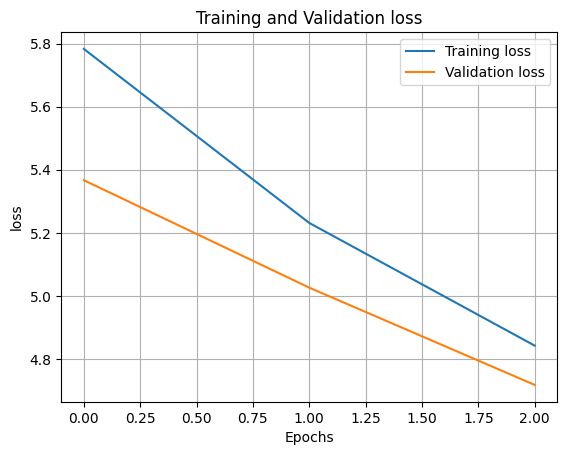

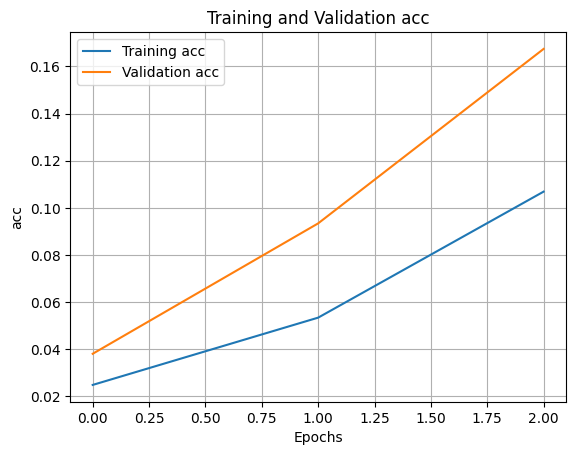

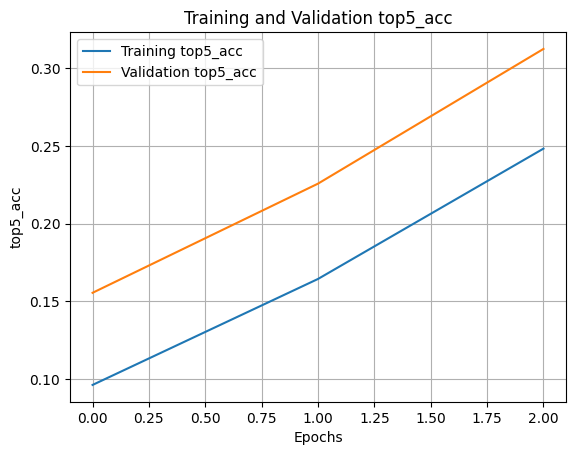

In [ ]:
plot_metric(history_with_fine_tuning, 'loss' )
plot_metric(history_with_fine_tuning, 'acc' )
plot_metric(history_with_fine_tuning, 'top5_acc' )

In [ ]:
from datetime import datetime

time_now = datetime.now().strftime('%d%m%Y_%H%M%S')

# Save the trained model
model_save_path = f'{model_name}_{num_epochs}epochs_{time_now}.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to distiltbert_hs04_classifier_fine_tuned_3epochs_29052025_110327_test.pth


____

### Embeddings with Fine-tuned DistilBERT

Using pretrained NLP model for contextual representation

distilbert-base-uncased

In [ ]:
# Custom Dataset for embeddings
class HSDescEmbedDataset(Dataset):
    def __init__(self, dataframe, tokenizer, desc_col='', label_col='', max_length=500):
        self.texts = dataframe[desc_col].fillna("").tolist()
        self.labels = dataframe[label_col].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': self.labels[idx]
        }

# Load tokenizer and model
model = DistilBertModel.from_pretrained("distilbert-base-uncased")
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
model.to(device)

# Function to extract [CLS] embeddings
def get_embeddings(dataloader, model, device):
    all_embeds = []
    all_labels = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attn = batch['attention_mask'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attn)
            # DistilBERT does not have pooler; use first token hidden state
            cls_embeds = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            all_embeds.append(cls_embeds)
            all_labels.extend(batch['label'])
    return np.vstack(all_embeds), np.array(all_labels)

#### Goods description emb

In [32]:
df_emb = df.sample(n=len(df)//20)

In [33]:
df_emb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13389 entries, 186910 to 136847
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   HS06                         13389 non-null  object 
 1   GOODS_DESCRIPTION            13389 non-null  object 
 2   HS04                         13389 non-null  object 
 3   HS02                         13389 non-null  object 
 4   full_eng                     12754 non-null  object 
 5   GOODS_DESCRIPTION_len_words  13389 non-null  int64  
 6   GOODS_DESCRIPTION_len_chars  13389 non-null  int64  
 7   subtokenization_indicator    13389 non-null  float64
dtypes: float64(1), int64(2), object(5)
memory usage: 941.4+ KB


Generating embs from goods descriptions

In [ ]:
# # Build dataset and loader
# ds = HSDescEmbedDataset(df_emb, tokenizer, desc_col='GOODS_DESCRIPTION', label_col='HS02', max_length=300)
# loader = DataLoader(ds, batch_size=32, shuffle=False)

# embeds, labels = get_embeddings(loader, model, device)
# print("Embeddings shape:", embeds.shape)

Saving embeddings

In [35]:
# EMB_n_LABELS_FILE = "good_desc_sample_embs_labels.npz"

# np.savez(EMB_n_LABELS_FILE, embeds=embeds, labels=labels)
# print("💾 Saved embeddings and labels to disk.")

Loading embeddings

In [36]:
EMB_n_LABELS_FILE = "good_desc_sample_embs_labels.npz"

if os.path.exists(EMB_n_LABELS_FILE):
    data = np.load(EMB_n_LABELS_FILE, allow_pickle=True)
    embeds = data["embeds"]
    labels = data["labels"]
    print("✅ Loaded cached embeddings and labels")
else:
    raise FileNotFoundError(f"{EMB_n_LABELS_FILE} not found – run get_embeddings first.")

✅ Loaded cached embeddings and labels


Viz embeddings with PCA

In [37]:
def pca_viz_embs(embeds, labels, n_componets=2, title='',
                 legend_title='', html_output_file=''):

    pca = PCA(n_components=n_componets)
    emb = pca.fit_transform(embeds)

    fig = go.Figure()
    for chap in np.unique(labels):
        mask = labels == chap
        if n_componets==2:
            fig.add_trace(go.Scatter(
                x=emb[mask, 0],
                y=emb[mask, 1],
                mode='markers',
                name=chap,
                marker=dict(size=4),
                hovertext=[chap]*mask.sum(),
                hoverinfo='text'
            ))
        elif n_componets==3:
            fig.add_trace(go.Scatter3d(
                x=emb[mask, 0],
                y=emb[mask, 1],
                z=emb[mask, 2],
                mode='markers',
                name=chap,
                marker=dict(size=3),
                hovertext=[chap]*mask.sum(),
                hoverinfo='text'
            ))
        else:
            return 
    if n_componets==2:
        scene = dict(
            xaxis_title="PC1", yaxis_title="PC2")
    elif n_componets==3:
        scene = dict(
            xaxis_title="PC1", yaxis_title="PC2", zaxis_title="PC3")
    else:
        return 
    fig.update_layout(
        title=title,
        scene=scene,
        legend_title=legend_title,
        width=1200, height=900
    )
    fig.write_html(html_output_file)
    print(f"📄 Saved plot to {html_output_file}")

In [38]:
# pca_viz_embs(embeds, labels, n_componets=2,
#              title="Goods Description sampled - 2D PCA of DistilBERT Embeddings",
#              legend_title="HS02 Chapter",
#              html_output_file="embeddings_2d_goods_desc_sampled.html")


In [39]:
# pca_viz_embs(embeds, labels, n_componets=3,
#              title="Goods Description sampled - 3D PCA of DistilBERT Embeddings",
#              legend_title="HS02 Chapter",
#              html_output_file="embeddings_3d_goods_desc_sampled.html")

#### HS06 nomenclature emb 

In [40]:
# Add HS02 (chapter) and HS04 (heading)
df_hs06['HS04'] = df_hs06.index.str[:4]
df_hs06['HS02'] = df_hs06.index.str[:2]

df_hs06

,full_eng,HS04,HS02
hs06,,,
010120,"Live horses, asses, mules and hinnies. && - Ho...",0101,01
010121,"Live horses, asses, mules and hinnies. && - Ho...",0101,01
010129,"Live horses, asses, mules and hinnies. && - Ho...",0101,01
010130,"Live horses, asses, mules and hinnies. && - Asses",0101,01
010190,"Live horses, asses, mules and hinnies. && - Other",0101,01
...,...,...,...
961590,"Combs, hair-slides and the like; hairpins, cur...",9615,96
961610,"Scent sprays and similar toilet sprays, and mo...",9616,96
961620,"Scent sprays and similar toilet sprays, and mo...",9616,96


Generating embs from full_eng nomenclature

In [41]:
# # Build dataset and loader
# ds = HSDescEmbedDataset(df_hs06, tokenizer, desc_col='full_eng', label_col='HS02', max_length=500)
# loader = DataLoader(ds, batch_size=32, shuffle=False)

# embeds, labels = get_embeddings(loader, model, device)
# print("Embeddings shape:", embeds.shape)

Saving embeddings

In [42]:
# EMB_n_LABELS_FILE = "hs02_fulleng_embs_labels.npz"

# np.savez(EMB_n_LABELS_FILE, embeds=embeds, labels=labels)
# print("💾 Saved embeddings and labels to disk.")

Loading embeddings

In [43]:
EMB_n_LABELS_FILE = "hs02_fulleng_embs_labels.npz"

if os.path.exists(EMB_n_LABELS_FILE):
    data = np.load(EMB_n_LABELS_FILE, allow_pickle=True)
    embeds = data["embeds"]
    labels = data["labels"]
    print("✅ Loaded cached embeddings and labels")
else:
    raise FileNotFoundError(f"{EMB_n_LABELS_FILE} not found – run get_embeddings first.")

✅ Loaded cached embeddings and labels


Viz embeddings with PCA

In [44]:
# pca_viz_embs(embeds, labels, n_componets=2,
#              title="HS06 full eng - 2D PCA of DistilBERT Embeddings",
#              legend_title="HS02 Chapter",
#              html_output_file="embeddings_2d_hs06_full_eng.html")

In [45]:
# pca_viz_embs(embeds, labels, n_componets=3,
#              title="HS06 full eng - 3D PCA of DistilBERT Embeddings",
#              legend_title="HS02 Chapter",
#              html_output_file="embeddings_3d_hs06_full_eng.html")

#### Goods desc vs. HS06 full eng embs

For similarity analysis

Full goods descriptions embs

In [46]:
# # Goods description (gd) for HS06 embeddings
# ds_gd = HSDescEmbedDataset(df, tokenizer, desc_col='GOODS_DESCRIPTION', label_col='HS06', max_length=500)
# loader_gd = DataLoader(ds_gd, batch_size=32, shuffle=False)

# gd_embeds, hs06_gd_labels = get_embeddings(loader_gd, model, device)
# print("Embeddings shape:", gd_embeds.shape)

Saving embs

In [47]:
# EMB_n_LABELS_FILE = "good_desc_embs_labels.npz"

# np.savez(EMB_n_LABELS_FILE, embeds=gd_embeds, labels=hs06_gd_labels)
# print("💾 Saved embeddings and labels to disk.")

HS06 full eng legal text embs

In [48]:
# # HS full eng (hs) sampled for HS06 embeddings
# ds_hs = HSDescEmbedDataset(df_hs06.reset_index(inplace=False), tokenizer, desc_col='full_eng', label_col='hs06', max_length=500)
# loader_hs = DataLoader(ds_hs, batch_size=32, shuffle=False)

# hs_embeds, hs_labels = get_embeddings(loader_hs, model, device)
# print("Embeddings shape:", hs_embeds.shape)

Saving embs

In [49]:
# EMB_n_LABELS_FILE = "hs06_fulleng_embs_labels.npz"

# np.savez(EMB_n_LABELS_FILE, embeds=hs_embeds, labels=hs_labels)
# print("💾 Saved embeddings and labels to disk.")

Caculating cosine similarity

In [50]:
# import numpy as np
# from sklearn.metrics.pairwise import cosine_similarity

# # Map HS06 code → corresponding legal text embedding
# # Normalize hs06 codes as string if necessary
# hs06_to_hsvec = {}
# for hs_code, emb in zip(hs_labels, hs_embeds):
#     hs06_to_hsvec[str(hs_code)] = emb

# # Compute cosine similarity for each GOODS_DESCRIPTION embedding
# cosine_sims = []

# for i in range(len(gd_embeds)):
#     hs_code = str(hs06_gd_labels[i])  # ensure string matching
#     gd_vec = gd_embeds[i].reshape(1, -1)  # shape (1, dim)

#     hs_vec = hs06_to_hsvec.get(hs_code)

#     if hs_vec is not None:
#         hs_vec = hs_vec.reshape(1, -1)
#         sim = cosine_similarity(gd_vec, hs_vec)[0][0]
#     else:
#         sim = np.nan  # if no match found, assign NaN

#     cosine_sims.append(sim)

# # Add results to df_emb
# df['cosine_sim_gd_vs_hs_text'] = cosine_sims

In [51]:
df.describe()

,GOODS_DESCRIPTION_len_words,GOODS_DESCRIPTION_len_chars,subtokenization_indicator
count,267780.000000,267780.000000,267780.000000
mean,4.588498,29.223411,1.947238
std,2.887145,18.470528,1.207913
min,1.000000,2.000000,1.000000
25%,3.000000,17.000000,1.250000
50%,4.000000,25.000000,1.666667
75%,6.000000,36.000000,2.285714
max,41.000000,150.000000,59.000000


Saving dataframe with all features and with cosine similarity

In [52]:
# df.to_csv("data/df_all_eda_features.csv")

In [53]:
df = pd.read_csv("data/df_all_eda_features.csv", index_col=0)

Top similarities

In [54]:
cols = ['HS06', 'GOODS_DESCRIPTION', 'full_eng', 'cosine_sim_gd_vs_hs_text']

In [55]:
print("Top 10 cosine similarity between goods description and HS06 full eng description:\n")
print(df[cols].dropna().sort_values(by='cosine_sim_gd_vs_hs_text', ascending=False).head(10).to_markdown(), "\n")

Top 10 cosine similarity between goods description and HS06 full eng description:

|        |   HS06 | GOODS_DESCRIPTION                                                                | full_eng                                                                                                                           |   cosine_sim_gd_vs_hs_text |
|-------:|-------:|:---------------------------------------------------------------------------------|:-----------------------------------------------------------------------------------------------------------------------------------|---------------------------:|
|  45158 | 640299 | Other:Other footwear with outer soles and uppers of rubber or pla:Other footwear | Other footwear with outer soles and uppers of rubber or plastics. && - Other footwear : && -- Other                                |                   0.98534  |
| 189750 | 520939 | Other fabrics:Woven fabrics of cotton, containing 85 % or more by weight of:Dyed | Woven fabrics of co

Top distances

In [56]:
print("Bottom 10 cosine similarity between goods description and HS06 full eng description:\n")
print(df[cols].dropna().sort_values(by='cosine_sim_gd_vs_hs_text', ascending=False).tail(10).to_markdown(), "\n")

Bottom 10 cosine similarity between goods description and HS06 full eng description:

|        |   HS06 | GOODS_DESCRIPTION                         | full_eng                                                                                                                                                                                                                               |   cosine_sim_gd_vs_hs_text |
|-------:|-------:|:------------------------------------------|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|---------------------------:|
| 247611 | 741820 | SHOWER HEAD SQUARE BLACK 260X 190mm       | Table, kitchen or other household articles and parts thereof, of copper; pot scourers and scouring or polishing pads, gloves and the like, of copper; sanitary ware and parts thereof, of copper. && -

Average similarity

In [57]:
sim_mean = df['cosine_sim_gd_vs_hs_text'].mean()
upper = sim_mean + sim_mean / 100
lower = sim_mean - sim_mean / 100

In [58]:
print("Regular cosine similarity between goods description and HS06 full eng description:\n")
print(df[cols].loc[(df['cosine_sim_gd_vs_hs_text'] < upper) & (df['cosine_sim_gd_vs_hs_text'] > lower)].head(10), "\n")

Regular cosine similarity between goods description and HS06 full eng description:

      HS06                               GOODS_DESCRIPTION  \
5   853950                    ASSY LED Base Strobe Upgrade   
9   220870                  VODKA FRAISE JELZIN STRAWBERRY   
18  620590                       SHORT SLEEVE REPAIR SHIRT   
27  732620                                      HANGER ROD   
32  843143             8-3/8SH Extension Overshot C-17208   
41  870323                              SUZUKI ESCUDO 2006   
48  841899  Spare Parts for 10 TR Air Cooled Water Chiller   
57  871120              USED CHANGZHOU KWANGYANG MOTORBYKE   
61  940540                          SURFACE MOUNTED LIGHTS   
67  842131                        FILTER ASSY, AIR CLEANER   

                                             full_eng  \
5   Electric filament or discharge lamps, includin...   
9   Undenatured ethyl alcohol of an alcoholic stre...   
18  Men's or boys' shirts. && - Of other textile m...   
27  O

Getting new stats from grouped HS06 codes

In [59]:
agg_col_for_sum = ['HS06']

agg_dict = {col: ['count'] for col in agg_col_for_sum}

agg_col_for_stats = ['GOODS_DESCRIPTION_len_words', 
                     'GOODS_DESCRIPTION_len_chars', 
                     'subtokenization_indicator',
                     'cosine_sim_gd_vs_hs_text']

agg_dict.update({col: ['sum','min', 'mean', 'median', 'max', 'std'] for col in agg_col_for_stats})


sum of cosine_sim_gd_vs_hs_text is not relevant

In [60]:
agg_dict

{'HS06': ['count'],
 'GOODS_DESCRIPTION_len_words': ['sum', 'min', 'mean', 'median', 'max', 'std'],
 'GOODS_DESCRIPTION_len_chars': ['sum', 'min', 'mean', 'median', 'max', 'std'],
 'subtokenization_indicator': ['sum', 'min', 'mean', 'median', 'max', 'std'],
 'cosine_sim_gd_vs_hs_text': ['sum', 'min', 'mean', 'median', 'max', 'std']}

In [61]:
stats_hs06 = df.groupby('HS06').agg(agg_dict)

stats_hs06

HS06 GOODS_DESCRIPTION_len_words                                     \
       count                         sum min      mean median max       std   
HS06                                                                          
10121      5                          30   4  6.000000    6.0   7  1.224745   
10130      1                           2   2  2.000000    2.0   2       NaN   
10190      1                           3   3  3.000000    3.0   3       NaN   
10221      5                          20   2  4.000000    3.0   7  2.345208   
10229      2                           8   3  4.000000    4.0   5  1.414214   
...      ...                         ...  ..       ...    ...  ..       ...   
970190    26                          98   1  3.769231    2.5  13  3.037205   
970200     1                           3   3  3.000000    3.0   3       NaN   
970300    31                         100   1  3.225806    2.0  12  2.261411   
970400     6                          16   1  2.666667    2.5   4  1.211060   
970500     4                          11   1  2.750000    2.0   6  2.217356   

       GOODS_DESCRIPTION_len_chars                 ...  \
                               sum min       mean  ...   
HS06                                               ...   
10121                          172  24  34.400000  ...   
10130                           16  16  16.000000  ...   
10190                           15  15  15.000000  ...   
10221                          103   8  20.600000  ...   
10229                           47  22  23.500000  ...   
...                            ...  ..        ...  ...   
970190                         621   6  23.884615  ...   
970200                          14  14  14.000000  ...   
970300                         672   9  21.677419  ...   
970400                         100   7  16.666667  ...   
970500                          75   8  18.750000  ...   

       subtokenization_indicator                                \
                            mean    median       max       std   
HS06                                                             
10121                   1.347619  1.285714  1.666667  0.251751   
10130                   1.500000  1.500000  1.500000       NaN   
10190                   1.000000  1.000000  1.000000       NaN   
10221                   1.400000  1.333333  2.000000  0.434613   
10229                   1.666667  1.666667  2.333333  0.942809   
...                          ...       ...       ...       ...   
970190                  1.443327  1.138889  4.000000  0.708957   
970200                  1.000000  1.000000  1.000000       NaN   
970300                  1.730108  1.500000  4.000000  0.844376   
970400                  1.166667  1.000000  1.750000  0.302765   
970500                  1.666667  1.500000  2.666667  0.816497   

       cosine_sim_gd_vs_hs_text                                          \
                            sum       min      mean    median       max   
HS06                                                                      
10121                  4.493902  0.889913  0.898780  0.894978  0.912786   
10130                  0.822331  0.822331  0.822331  0.822331  0.822331   
10190                  0.866746  0.866746  0.866746  0.866746  0.866746   
10221                  4.574999  0.876037  0.915000  0.915777  0.937644   
10229                  1.812984  0.888580  0.906492  0.906492  0.924403   
...                         ...       ...       ...       ...       ...   
970190                21.213793  0.742387  0.815915  0.813457  0.902661   
970200                 0.000000       NaN       NaN       NaN       NaN   
970300                 0.000000       NaN       NaN       NaN       NaN   
970400                 0.000000       NaN       NaN       NaN       NaN   
970500                 0.000000       NaN       NaN       NaN       NaN   

                  
             std  
HS06              
10121   0.009314  
10130        NaN  
10190        NaN 

Saving new stats

In [62]:
stats_hs06.to_csv('eda_stats_hs06_with_similarity.csv')

Report to html format

In [63]:
stats_hs06.columns = ['_'.join(col) for col in stats_hs06.columns]

ProfileReport(stats_hs06, title="HS06 Goods Description EDA").to_file("eda_stats_hs06_with_similarity.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

EDA Finished

Write report and present

______